In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2019-08-08 15:52:39--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   111MB/s    in 0.8s    

2019-08-08 15:52:40 (111 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3


In [4]:
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                               include_top=False,
                               weights=None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable=False
    
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [6]:
last_layer = pre_trained_model.get_layer('mixed7')
print('Output shape of layer: ', last_layer.output_shape)
last_output = last_layer.output

Output shape of layer:  (None, 7, 7, 768)


In [7]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.999):
            print('\n Reached accuracy of 99.9% so cancelling training')
            self.model.stop_training=True

In [8]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),
             loss='binary_crossentropy',
             metrics=['acc'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 
 

--2019-08-08 16:38:01--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   133MB/s    in 1.1s    

2019-08-08 16:38:02 (133 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2019-08-08 16:38:03--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/z

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import zipfile

In [12]:
local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/training')
zip_ref.close()

local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip)
zip_ref.extractall('/tmp/validation')
zip_ref.close()

In [14]:
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'


train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir = os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir = os.path.join(validation_dir, 'humans')

In [15]:
train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

In [16]:
print(len(train_horses_fnames))
print(len(train_humans_fnames))
print(len(validation_horses_fnames))
print(len(validation_humans_fnames))

500
527
128
128


In [18]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True)

validation_datagen = ImageDataGenerator( rescale=1./255. )

train_data_generator = train_datagen.flow_from_directory(train_dir,
                                                batch_size=20,
                                                class_mode='binary',
                                                target_size=(150,150))

validation_data_generator = validation_datagen.flow_from_directory(validation_dir,
                                                batch_size=20,
                                                class_mode='binary',
                                                target_size=(150,150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [20]:
callbacks = myCallback()

In [23]:
history = model.fit_generator(
    train_data_generator,
    validation_data=validation_data_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_steps=50,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/100
100/100 - 29s - loss: 0.1639 - acc: 0.9286 - val_loss: 0.0904 - val_acc: 0.9767
Epoch 2/100
100/100 - 23s - loss: 0.0690 - acc: 0.9726 - val_loss: 0.1939 - val_acc: 0.9717
Epoch 3/100
100/100 - 22s - loss: 0.0420 - acc: 0.9863 - val_loss: 0.0128 - val_acc: 0.9929
Epoch 4/100
100/100 - 22s - loss: 0.0240 - acc: 0.9930 - val_loss: 2.6188e-05 - val_acc: 1.0000
Epoch 5/100
100/100 - 22s - loss: 0.0558 - acc: 0.9787 - val_loss: 0.0223 - val_acc: 0.9970
Epoch 6/100
100/100 - 22s - loss: 0.0441 - acc: 0.9894 - val_loss: 0.2237 - val_acc: 0.9615
Epoch 7/100
100/100 - 22s - loss: 0.0282 - acc: 0.9908 - val_loss: 0.1027 - val_acc: 0.9848
Epoch 8/100
100/100 - 22s - loss: 0.0380 - acc: 0.9869 - val_loss: 0.0825 - val_acc: 0.9879
Epoch 9/100
100/100 - 22s - loss: 0.0283 - acc: 0.9919 - val_loss: 0.4192 - val_acc: 0.9595
Epoch 10/100
100/100 - 22s - loss: 0.0208 - acc: 0.9944 - val_loss: 0.4709 - val_acc: 0.9484
Epoch 11/100
100/100 - 22s - loss: 0.0338 - acc: 0.9894 - val_loss: 0.2455 

Epoch 90/100
100/100 - 22s - loss: 0.0065 - acc: 0.9980 - val_loss: 0.9485 - val_acc: 0.9565
Epoch 91/100
100/100 - 22s - loss: 0.0302 - acc: 0.9959 - val_loss: 0.8988 - val_acc: 0.9575
Epoch 92/100
100/100 - 21s - loss: 0.0061 - acc: 0.9985 - val_loss: 1.1264 - val_acc: 0.9524
Epoch 93/100
100/100 - 23s - loss: 0.0197 - acc: 0.9959 - val_loss: 0.6788 - val_acc: 0.9595
Epoch 94/100
100/100 - 23s - loss: 0.0052 - acc: 0.9985 - val_loss: 0.6299 - val_acc: 0.9636
Epoch 95/100
100/100 - 22s - loss: 0.0022 - acc: 0.9985 - val_loss: 1.1377 - val_acc: 0.9514
Epoch 96/100

 Reached accuracy of 99.9% so cancelling training
100/100 - 22s - loss: 0.0032 - acc: 0.9995 - val_loss: 1.6651 - val_acc: 0.9362


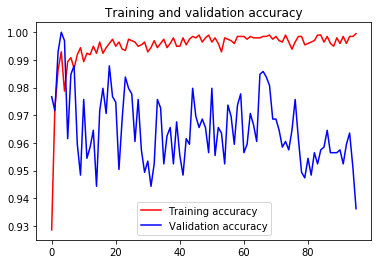

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()
